In [1]:
import uproot4
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from matplotlib import cm
from matplotlib.colors import LogNorm, Normalize
import awkward1 as ak
import os
from pathlib import Path
import pandas as pd
import numpy as np

from event_display import  build_calorimeter_section

In [2]:
from geant3_parser import build_train_set
from geant3_parser import Geant3DataFile

file_name = os.path.join('data', 'shower_geant3_new.dat')
data_file = Geant3DataFile(file_name, skip_lines=3)
input_data, true_e, sum_e = build_train_set(data_file, 10, add_real_xy=False, normalize=True)

inputs2 = input_data[:,2:]
inputs2 = np.reshape(inputs2, (len(inputs2), 11, 11, 1))  # -1 => autodetermine
# Pad with 1 row and column of zeroes, so it divides by 2
inputs2 = np.pad(inputs2, ((0,0), (0,1), (0,1), (0,0)), mode='constant', constant_values=0)
print(f"Inputs shape new = {np.shape(inputs2)}")

Time open 0.5849461555480957
Time split 0.27795910835266113
Inputs shape new = (10, 12, 12, 1)


In [3]:
def display_event(event_data, fig=None, ax=None):
    # constants
    cal_size = 12
    cell_size = 1    
    size_x = cell_size
    size_y = cell_size
    dx = size_x / 2.0
    dy = size_y / 2.0

    # go through all cells and calculate their centers
    centers = np.arange(-cal_size/2.0 + cell_size/2, cal_size/2 + cell_size/2, 1)
    positions = []
    for y_iter in range(cal_size):
        for x_iter in range(cal_size):
            positions.append((centers[x_iter], centers[y_iter]))

    # plot calorimeter with empty cells
    if not fig or not ax:
        fig, ax = plt.subplots()
    build_calorimeter_section(ax, positions, 1, 1)

    # Create a heat map
    norm = LogNorm()
    norm.autoscale(event_data)
    cmap = cm.get_cmap('inferno')

    # Convert data to rectangular patches    
    module_rects = []
    for y_iter in range(cal_size):
        for x_iter in range(cal_size):
            data_iter = y_iter*cal_size + x_iter
            x = centers[x_iter]
            y = centers[y_iter]
            weight = event_data[x_iter][y_iter][0]
            #print(x,y,weight)
            patch = patches.Rectangle((x-dx, y-dy), size_x, size_y, edgecolor='black', facecolor=cmap(norm(weight)))
            module_rects.append(patch)

    # plot rectangles with data
    col = PatchCollection(module_rects, match_original=True)
    ax.add_collection(col)

    # plot heatmap legend
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(event_data)
    fig.colorbar(sm)
    
    return fig, ax

(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

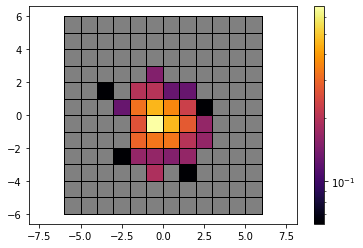

In [4]:
display_event(inputs2[0])


In [6]:
import math
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from geant3_parser import build_train_set
from geant3_parser import Geant3DataFile
import os

In [7]:
model = load_model('g3_autoencoder_conv_no_xy.hd5')

# Run ML on data
eval_e = model.predict(inputs2)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

display_event(inputs2[0], fig, ax1)
display_event(eval_e[0], fig, ax2)
#ax1.hist(true_e, bins=100)
#ax2.hist(sum_e/1000, bins=100)
plt.show()

(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

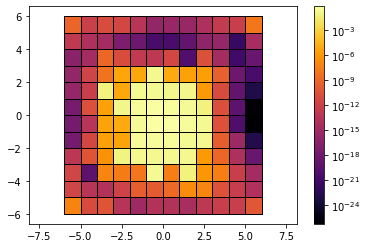

In [8]:
display_event(eval_e[0])

(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

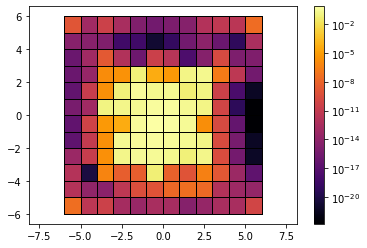

In [9]:
display_event(eval_e[1])

(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

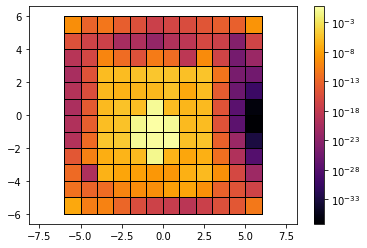

In [10]:
display_event(eval_e[2])